In [46]:
# 모듈 로딩
import spacy
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.classification import BinaryF1Score

# from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

In [47]:
# 데이터 준비
FILE_PATH = './naver.csv'

Cartoon_DF = pd.read_csv(FILE_PATH)
# Cartoon_Chal_DF = pd.read_csv(FILE_PATH2) => age 카테고리가 없음.

In [48]:
Cartoon_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           2100 non-null   int64  
 1   title        2100 non-null   object 
 2   author       2100 non-null   object 
 3   genre        2100 non-null   object 
 4   description  2100 non-null   object 
 5   rating       2100 non-null   float64
 6   date         2100 non-null   object 
 7   completed    2100 non-null   bool   
 8   age          1998 non-null   object 
 9   free         2100 non-null   bool   
 10  link         2100 non-null   object 
dtypes: bool(2), float64(1), int64(1), object(7)
memory usage: 151.9+ KB


In [49]:
Cartoon_DF['completed'] = Cartoon_DF['completed'].astype('int16')
Cartoon_DF['free'] = Cartoon_DF['free'].astype('int16')

In [50]:
Cartoon_DF = Cartoon_DF[~ Cartoon_DF['age'].isna()]

In [51]:
# 데이터 불균형이기 때문에 18세 이용가 날림
Cartoon_DF['age'].value_counts()

age
전체연령가      868
15세 이용가    578
12세 이용가    486
18세 이용가     66
Name: count, dtype: int64

In [52]:
Cartoon_DF = Cartoon_DF[~(Cartoon_DF['age'] == '18세 이용가')]

In [53]:
## target 수치화
target = []
for num in range(len(Cartoon_DF)):
    if Cartoon_DF.iloc[num]['age'] == '전체연령가': 
        target.append(0)
    elif Cartoon_DF.iloc[num]['age'] == '12세 이용가':
        target.append(1)
    elif Cartoon_DF.iloc[num]['age'] == '15세 이용가':
        target.append(2)

Cartoon_DF['target'] = target

In [54]:
Cartoon_DF.target.values

array([0, 1, 2, ..., 2, 1, 2], dtype=int64)

In [55]:
import re
def re_text(text):
    text = re.sub(r'[^ㄱ-ㅎ가-힣 ]+', ' ', text)
    text = text.replace('\xa0','')
    
    return text.strip()

In [56]:
Cartoon_DF['description'] = Cartoon_DF['description'].apply(re_text)

In [57]:
Cartoon_DF['description']

0       흔하디 흔한 재벌후계자와 캔디도 울고 갈 박복한 가난소녀의 파란만장 동거기 인기작 ...
1       이번 주인공은 돌이다 돌이지만 동료도 모으고 악당도 물리친다 랑또 작가표 동양 판타...
2       어느 날  인어가 내게 말을 걸어왔다  눈을 떠보니 총구가 있었다  그리고 몸이 연...
3          한국 최초 한국형 고교스포츠 웹툰 열혈따윈 개나 줘  낙오자들 뿐인 농구부의 운명은
4       사람은 좀 죽여도 싸우는건 싫어해요  게임에서조차 집 바깥을 나가지 않는  제리  ...
                              ...                        
2093    넌 내가 나비라는걸 알고 있잖아 알면서도 빠지고 싶은 사랑 투명한 동거  정서 작가...
2094       고객은 왕이 아니다  직원이 왕이다 병맛 드라마를 뛰어넘는 미친 상상력의 원작 웹툰
2096    악귀들이 가득찬 섬 제주도  이를 물리치는 토막살인범 반  웹툰으로 새롭게 돌아온 ...
2097       못생긴 얼굴에서 미인으로 새롭게 태어난 그녀  강미래  그런데  어디서 본 듯 한데
2098    악귀들이 가득찬 섬 제주도  이를 물리치는 토막살인범 반  웹툰으로 돌아온 퇴마만화...
Name: description, Length: 1932, dtype: object

In [58]:
# train, test 나누기
train = Cartoon_DF.sample(frac=0.8, random_state=42) # 랜덤으로 90를 선택
test = Cartoon_DF.drop(train.index)                  # 트레인을 삭제해서 비율을 train : test = 9: 1

# print(train.head(5))
# print('Training Data Size : ', len(train))
# print("Testing Data Size : ", len(test))

In [59]:
# 데이터 토큰화 및 단어 사전 구축
from konlpy.tag import *
from collections import Counter

## 단어사전을 만드는 함수
def build_vocab(corpus, n_vocab, special_tokens): #n_vocab은 최대 사용할 단어개수
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab): # 가장 많이 등장한 순서대로 상위 n_vocab개의 단어 반환
        vocab.append(token)
    return vocab

In [60]:
## 불용어 리스트 불러오는 함수
STOP_PATH = r'C:\Users\KDP-14\Desktop\VSCode\KDT6\FLASK_AI\mini_project\jang_stopwords.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() # 문장단위로
    return set(stopwords)

In [61]:
stopwords = make_stopwords(STOP_PATH)

In [62]:
train

,id,title,author,genre,description,rating,date,completed,age,free,link,target
1169,640050,엄마와 딸 x2,필냉이,"에피소드, 일상",인자한 외할머니 깐깐한 엄마 엉뚱한 딸이 한 집에 살게 되었다 본격 삼대모녀 티...,9.97,2016.03.10 23:13,1,전체연령가,0,https://comic.naver.com/webtoon/list?titleId=6...,0
1789,759894,평화선도부,최경민 / 용성,"스토리, 액션",선도 시켜 주마 학교폭력으로 얼룩진 구천 막나가는 구천의 일진들을 선도시키기 위...,8.81,2021.04.20 23:02,1,15세 이용가,1,https://comic.naver.com/webtoon/list?titleId=7...,2
2029,717059,12차원 소년들,컷부,"옴니버스, 개그",소무하보다 더 강해진 녀석들이 돌아왔다 차원을 넘나드는 소년들의 다양한 이야기,9.89,2019.08.20 23:07,1,전체연령가,1,https://comic.naver.com/webtoon/list?titleId=7...,0
1022,748409,신의한수,이순기 / 민홍기,"스토리, 드라마",여기 배신으로 점철된 삶을 살아온 한 여자가 있다 그녀는 사람이면 학을 떼는 냉소...,9.54,2020.06.29 10:00,1,전체연령가,1,https://comic.naver.com/webtoon/list?titleId=7...,0
350,169081,단군할배요,호연,"스토리, 드라마",대한민국 어느 깊은 산골에서 다섯 살 아가씨가 산신을 만난다 단기 년 단군이...,9.91,2011.09.29 00:14,1,전체연령가,0,https://comic.naver.com/webtoon/list?titleId=1...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
707,796302,베니루 BAENIRU,우지금,"스토리, 스릴러",하루하루 죽지 못해 사는 배지현 어느 날 어마어마한 수익을 내는 걸로 유명한 버...,9.87,2022.12.28 22:56,0,15세 이용가,0,https://comic.naver.com/webtoon/list?titleId=7...,2
1701,169082,키스우드,안성호,"스토리, 판타지",언덕이라 불리우는 정체 불명의 숲 그리고 그곳을 지배 하고있는 소녀 무아 무아의...,9.95,2011.01.29 14:43,1,전체연령가,0,https://comic.naver.com/webtoon/list?titleId=1...,0
1105,602923,안 돼요 마왕님!,마로,"스토리, 로맨스",인터넷 소설 마니아 마왕 진정한 사랑을 찾아 인간계로 떠나다 본격 순정 코미디,9.96,2015.09.24 23:13,1,전체연령가,0,https://comic.naver.com/webtoon/list?titleId=6...,0
1739,784813,퇴마록,운 / 이협 / 이우혁,"스토리, 액션",대한민국에 신드롬을 일으키며 판매 누적부수 만부 이상을 기록한 대작 판타지를 이제...,9.93,2022.12.29 22:00,0,전체연령가,1,https://comic.naver.com/webtoon/list?titleId=7...,0


In [63]:
tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords ] for review in train.description]   
test_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in test.description]

vocab = build_vocab(corpus=train_tokens, n_vocab=10000, special_tokens=["<pad>", "<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)} 
id_to_token = {idx: token for idx, token in enumerate(vocab)} 

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '수', '시작', '사람', '이야기', '그녀', '날', '작가', '남자']
10002


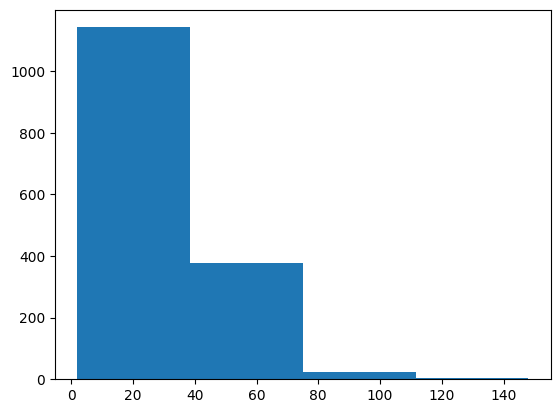

In [64]:
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen,bins=4)
plt.show()

In [65]:
## 정수 인코딩 및 패딩
import numpy as np
# 패딩까지 해주는 함수
def pad_sequences(sequences, max_length, pad_value):  
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] 
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length   
        result.append(padded_sequence)
    return np.asarray(result)   

In [66]:
unk_id = token_to_id["<unk>"]   
train_ids = [[token_to_id.get(token, unk_id) for token in review] for review in train_tokens]  
test_ids = [[token_to_id.get(token, unk_id) for token in review] for review in test_tokens]

max_length = 35
pad_id = token_to_id["<pad>"]   
train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[5013 5014 5015  150 1746  181   49   26   14  169  218 3139 3140 5016
   57   80    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
[  46 1993 1993  637    1 1436 1595    1  405  258    1 6064   58    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [67]:
## 데이터로더
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.target.values, dtype=torch.float32)
test_labels = torch.tensor(test.target.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [68]:
for feature, label in train_loader:
    print(feature)
    print(label)
    break

tensor([[4583, 4584,  238,  499,   47, 3549, 8728,  646,   56, 8729, 8730,  900,
          493, 8731, 2522,  145, 8732, 4585,  740, 1404, 4583, 4584, 1642, 8733,
         2213,  712,  589,  102,  889, 2262,    0,    0,    0,    0,    0],
        [   4, 1476,   65,    1,    2,  604,    1, 4505,    1,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 347,   28, 1728,  680,   90, 2008,  276,  253,   54, 4263,   61,  776,
         1214, 3355,  183,  218, 3385,    5,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [  12,  961,   14,  721, 1900, 2636, 3744, 6298, 3745, 3746,  755, 3747,
          538, 2015, 6299, 3748, 6300,  347,  295,   62,   50, 3749, 3746,  143,
         6301,  743, 2637,  677,    9, 1339, 6302, 1114,    4,   16, 6303],
        [8116, 1098, 8117,  229, 2681,  980, 811

In [69]:
# 문장 분류하는 모델
class SentenceClassifier(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, n_classes ,dropout=0.5, bidirectional=True, model_type="lstm"):
        super().__init__()  # 부모클래스 상속

        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embedding_dim, padding_idx=0)

        # rnn모델 일 경우
        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )
        # lstm모델 일 경우
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True
            )

        # bidirectional은 양방향성을 의미하는 파라미터
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, n_classes)   # 양방향일때 타임스탭에서 양방향의 정보(순방향,역방향)의 출력들을 결합하여 분류기에 전달
        else:
            self.classifier = nn.Linear(hidden_dim, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings) 
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [70]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [71]:
## 손실 함수와 최적화 함수 정의
from torch import optim
LR = 0.001
n_vocab = len(token_to_id)   # 단어사전의 크기
hidden_dim = 128     # 은닉 사태의 크기
embedding_dim = 128   #임베딩 벡터의 차원 128차원으로 사용
n_layers = 2     # 2층
n_classes = 3 # 다중 분류라 3

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers, n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)   
optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [72]:
# 모델 학습하는 함수
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).long() # 다중분류에선 없애야 됨 => .unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

In [73]:
# 모델 테스트하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).long() # 다중분류에선 없애야 됨 => .unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.argmax(torch.softmax(logits,dim=1),dim=1)  # softmax는 자동으로 해줌 >.5  
        corrects.extend(torch.eq(yhat, labels).cpu().tolist())        

        val_loss = np.mean(losses)
        val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")
    return val_loss

In [74]:
epochs = 100
interval = 500   

for epoch in range(epochs):
    print(f'epoch : {epoch}')
    train(classifier, train_loader, criterion, optimizer, device, interval)
    val_loss = test(classifier, test_loader, criterion, device)
    scheduler.step(val_loss)

epoch : 0
Train Loss 0 : 1.1104782819747925
Val Loss : 1.0639160561561585, Val Accuracy : 0.45595854922279794
epoch : 1
Train Loss 0 : 1.1259268522262573
Val Loss : 1.0654229307174683, Val Accuracy : 0.46632124352331605
epoch : 2
Train Loss 0 : 1.0162863731384277
Val Loss : 1.1576833486557008, Val Accuracy : 0.38341968911917096
epoch : 3
Train Loss 0 : 0.7271687984466553
Val Loss : 1.2601211166381836, Val Accuracy : 0.39896373056994816
epoch : 4
Train Loss 0 : 0.5650665163993835
Val Loss : 1.4338971018791198, Val Accuracy : 0.4170984455958549
epoch : 5
Train Loss 0 : 0.4801551103591919
Val Loss : 1.4178925943374634, Val Accuracy : 0.4378238341968912
epoch : 6
Train Loss 0 : 0.6542354226112366
Val Loss : 1.6872745490074157, Val Accuracy : 0.3963730569948187
epoch : 7
Train Loss 0 : 0.2509300112724304
Val Loss : 1.8624946975708008, Val Accuracy : 0.4170984455958549
epoch : 8
Train Loss 0 : 0.0922357439994812
Val Loss : 1.9105742645263672, Val Accuracy : 0.4067357512953368
epoch : 9
Train

KeyboardInterrupt: 

In [675]:
torch.save(classifier, f'best_model.pth1')

In [680]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model=torch.load('best_model.pth', weights_only=False).to(device)

In [681]:
new_reviews = ["너무 폭력적이여서 재미가 없었어"]

In [682]:
new_reviews = [re_text(review) for review in new_reviews]
new_tokens = [[token for token in tokenizer.morphs(review) if token not in stopwords] for review in new_reviews]
new_ids = [[token_to_id.get(token, unk_id) for token in tokens] for tokens in new_tokens]
new_ids_padded = pad_sequences(new_ids, max_length, pad_id)
new_ids_tensor = torch.tensor(new_ids_padded).to(device)

In [684]:
## 예측
model.eval()
with torch.no_grad():
    outputs = model(new_ids_tensor)
    predictions = torch.softmax(outputs)

# 9. 예측 결과 출력 (0.5 이상이면 긍정, 미만이면 부정)
for i, review in enumerate(new_reviews):
    prediction = 1 if predictions[i] >= 0.5 else 0
    print(f"리뷰: {review}")
    print(f"예측된 결과: {'긍정' if prediction == 1
                      else '부정'}")

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [685]:
import pickle
# 단어 사전 저장
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


In [686]:
import pickle

# 단어 사전 불러오기
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

print("단어 사전이 불러와졌습니다.")
print(vocab)

단어 사전이 불러와졌습니다.
['<pad>', '<unk>', '수', '시작', '사람', '이야기', '작가', '날', '남자', '세상', '사랑', '속', '인간', '로맨스', '남', '앞', '세계', '친구', '소녀', '게임', '학교', '삶', '인생', '웹툰', '소년', '결혼', '연애', '비밀', '후', '눈', '집', '신작', '사건', '생활', '주인공', '일상', '번', '말', '정체', '꿈', '은', '중', '판타지', '여자', '만화', '마음', '몸', '건', '존재', '운명', '명', '능력', '죽음', '과거', '곳', '귀신', '현실', '끝', '제안', '가족', '최고', '기억', '복수', '고등학생', '드라마', '반', '생각', '성장', '미래', '순간', '완벽', '게', '차', '저주', '위기', '대한민국', '악마', '거', '소설', '행복', '안', '채', '애', '사고', '김', '강', '뿐', '전설', '적', '남편', '고등학교', '시절', '사실', '딸', '학생', '싸움', '신', '우', '목숨', '인기', '액션', '힘', '전', '처음', '천재', '한', '방', '엄마', '뒤', '하루', '회사', '지', '인', '마법', '빙의', '최강', '등장', '지옥', '인해', '왕', '단편', '외모', '돈', '발견', '아이돌', '선', '청춘', '네이버', '지구', '선택', '모험', '관계', '마을', '상황', '길', '계약', '시대', '이름', '우주', '첫사랑', '밤', '손', '정신', '서로', '때문', '덕', '작품', '진실', '도', '이유', '간', '동생', '모습', '성공', '마지막', '멸망', '인류', '주변', '짝사랑', '전생', '부', '윤', '기회', '대', '조선', '결심', '만', '여행', '일진', 

In [687]:
import seaborn as sns

# 모델 테스트하고 혼동 행렬을 시각화하는 함수
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    # 실제 레이블과 예측 값을 저장할 리스트
    all_labels = []
    all_predictions = []

    for step, (input_ids, labels) in enumerate(datasets):   
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)  
        loss = criterion(logits, labels)
        losses.append(loss.item())

        # 예측 값과 실제 값을 리스트에 추가
        yhat = torch.sigmoid(logits) > 0.5  
        all_labels.extend(labels.cpu().tolist())  # 실제 레이블
        all_predictions.extend(yhat.cpu().tolist())  # 예측 값

        corrects.extend(torch.eq(yhat, labels).cpu().tolist())

    val_loss = np.mean(losses)
    val_accuracy = np.mean(corrects)

    print(f"Val Loss : {val_loss}, Val Accuracy : {val_accuracy}")

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_predictions)

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return val_loss

In [688]:
val_loss = test(classifier, test_loader, criterion, device)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported